# Getting started

Here we will briefly demonstrate loading in ellipsometry datasets, creating a model and optimising that model to the dataset. For a more detailed description of model creation, please see the [getting started](https://refnx.readthedocs.io/en/latest/getting_started.html) tutorial on *refnx*.

## Fitting an ellipsometry dataset

We begin by importing all of the relevant packages.

In [1]:
import sys
import os
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
import scipy

import refnx
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

import refellips
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.structureSE import RI, Cauchy, load_material

For reproducibility, it is important to note the versions of software that you're using.

In [2]:
print(
    f"refellips: {refellips.version.version}\n"
    f"refnx: {refnx.version.version}\n"
    f"scipy: {scipy.version.version}\n"
    f"numpy: {np.version.version}"
)

refellips: 0.0.3.dev0+92f1c50
refnx: 0.1.30
scipy: 1.8.0
numpy: 1.22.3


### Loading a dataset

*refellips* has the capability of loading data directly from output files of both Accurion EP3 and EP4 ellipsometers, as well as Horiba ellipsometers using `open_EP4file` and `open_HORIBAfile` respectively.

Alternatively, other datasets can be imported using `DataSE`. The file must be formatted to contain four columns: wavelength, angle of incidence, psi and delta.

In [3]:
pth = os.path.dirname(refellips.__file__)
dname = "testData1_11nm_PNIPAM_on_Si_EP4.dat"
file_path = pjoin(pth, "../", "demos", dname)

We will now use `DataSE` to import our dataset.

In [4]:
data = DataSE(data=file_path)

### Creating a model for our interface

As with *refnx*, `ComponentSE` objects are assembled into a `StructureSE` object which describes the interface. The simplest of these `ComponentSE` objects is a `SlabSE`, which is what we will use here.

We begin by loading in dispersion curves which describe the refractive index for each layer within our `StructureSE` (i.e., for each `ComponentSE`). *refellips* offers multiple ways to prescribe the refractive index of a layer. Here we will demonstrate the different ways to prescribe refractive indices. 
- `RI()`: Users can provide a refractive index ($n$) and extinction coefficient ($k$) for a given wavelength by `RI([n, k])` or alternatively, for spectroscopic analysis users load in their own dispersion curve of $n$,$k$ as a function of wavelength by providing a path to the desired file as `RI('my_materials\material.csv')`.
- `Cauchy()`: Creates a dispersion curve of a given material using the provided $a$, $b$ and $c$ values.
- `load_material()`: Searches the *refellips* materials database for the provided material.

Note, dispersion curves provided in the *refellips* materials database are downloaded as a .csv file from [refractiveindex.info](https://refractiveindex.info/). When providing a dispersion curve, files must contain at least two columns, assumed to be wavelength (in microns) and refractive index. If three columns are provided the third is loaded as the extinction coefficient. Further details on modelling material optical properties are provided on the [FAQ](https://refellips.readthedocs.io/en/latest/faq.html#where-do-i-find-dispersion-curves-for-a-material) page.

In [5]:
si = load_material("silicon")
sio2 = RI([1.4563, 0])
PNIPAM = Cauchy(1.47, 0.00495)
air = RI(pjoin(pth, "materials/air.csv"))

Now we have defined the refractive indices of our layers, we can create a `Slab` object for each interfacial layer.

In [6]:
# this is a 20 Angstrom layer
silica_layer = sio2(20)

polymer_layer = PNIPAM(200)

Each `Slab` has an associated thickness (as defined above), roughness, and volume fraction of solvent. As this is a dry film we will leave `vfsolv` as 0.

In [7]:
silica_layer.name = "Silica"
silica_layer.thick.setp(vary=True, bounds=(1, 30))
silica_layer.vfsolv.setp(vary=False, value=0)

polymer_layer.name = "PNIPAM"
polymer_layer.thick.setp(vary=True, bounds=(100, 500))
polymer_layer.vfsolv.setp(vary=False, value=0)

We now create the `Structure` by assembling the `Component` objects. Our structure is defined from fronting to backing, where the thickness of the fronting and backing are defined to be infinite (i.e., `np.inf`).

In [8]:
structure = air() | polymer_layer | silica_layer | si()

Finally, we can create our model. A wavelength must be provided here, however, if your ellipsometry dataset contains a wavelength that will be automatically used. We have the option to define the `delta_offset` parameter here.

In [9]:
model = ReflectModelSE(structure)

model.delta_offset.setp(value=0, vary=False, bounds=(-10, 10))

We can now have a quick preview of how our model compares to our dataset prior to fitting.

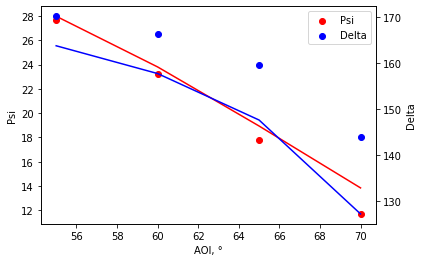

In [10]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50, 75, 100)

for dat in data.unique_wavelength_data():
    wavelength, aois, psi_d, delta_d = dat
    wavelength_aois = np.c_[np.ones_like(aois) * wavelength, aois]

    psi, delta = model(wavelength_aois)
    ax.plot(aois, psi, color="r")
    p = ax.scatter(data.aoi, data.psi, color="r")

    axt.plot(aois, delta, color="b")
    d = axt.scatter(data.aoi, data.delta, color="b")

ax.legend(handles=[p, d], labels=["Psi", "Delta"])
ax.set(ylabel="Psi", xlabel="AOI, °")
axt.set(ylabel="Delta")
plt.show()

### Creating an objective

We will now create an objective. The `Objective` object is made by combining the model and the data, and is used to calculate statistics during the fitting process.

In [11]:
objective = ObjectiveSE(model, data)

### Fitting the data

The optimisation of our `Objective` is performed by *refnx*'s `CurveFitter`. Data can be fit using a local optimisation such as `least_squares`, or a more global optimisation technique such as `differential_evolution`. For more information on the available fitting methods, see [*refnx*](https://refnx.readthedocs.io/en/latest/refnx.analysis.html#refnx.analysis.CurveFitter.fit).

In [12]:
fitter = CurveFitter(objective)
fitter.fit(method="least_squares");

### Optimised model and data post fit

We can now view our optimised objective, including our fit parameters. Users can plot this using the above method, or alternatively use the `objectiveSE.plot()` function.

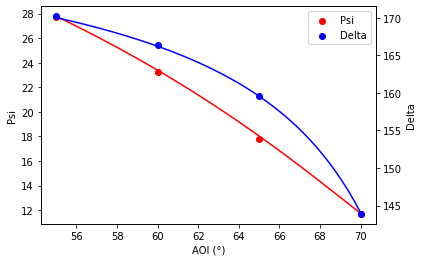

In [13]:
fig, ax = objective.plot()

In [14]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-10.0, 10.0]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:    'PNIPAM'    
<Parameter:  ' - thick'   , value=132.339  +/- 982 , bounds=[100.0, 500.0]>
<Parameter: ' - cauchy A' , value=1.47 (fixed)  , bounds=[-inf, inf]>
<Parameter: ' - cauchy B' , value=0.00495 (fixed)  , bounds=[-inf, inf]>
<Parameter: ' - cauchy C' , value=0 (fixed)  , bounds=[-inf, in

We can also view the resultant refractive index profile of the interface as well.

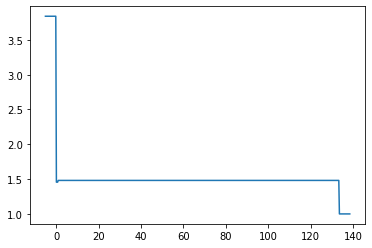

In [15]:
structure.reverse_structure = True
plt.plot(*structure.ri_profile())

### Using the plotting tools

In [16]:
sys.path.insert(1, "../tools")
from plottools import plot_ellipsdata, plot_structure

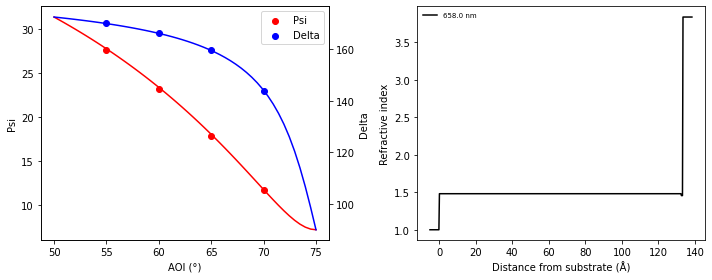

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_ellipsdata(ax[0], data=data, model=model, xaxis="aoi")
plot_structure(ax[1], objective=objective)

fig.tight_layout()

### Saving the objective

If you would like to save the `Objective` or model to a file, this is best done through serialisation to a Python pickle.

In [19]:
import pickle

pickle.dump(objective, open("my_objective.pkl", "wb"))

You can then simply reload your objective.

In [20]:
objective = pickle.load(open("my_objective.pkl", "rb"))

If you would like to save your objective as a `.csv` file, this can be done as below.

In [21]:
with open("my_objective.csv", "wb") as fh:
    data = objective.data
    wav = data.wavelength
    aoi = data.aoi
    psi_d = data.psi
    delta_d = data.delta
    for dat in data.unique_wavelength_data():
        wavelength, aois, psi_d, delta_d = dat
        wavelength_aois = np.c_[np.ones_like(aois) * wavelength, aois]
        psi_m, delta_m = objective.model(wavelength_aois)
    save_arr = np.array([wav, aoi, psi_d, delta_d, psi_m, delta_m])

    np.savetxt(
        fh,
        save_arr.T,
        delimiter=",",
        header="Wavelength, AOI, Measured Psi, Measured Delta, Modelled Psi, Modelled Delta",
    )